# Objective

Churn is when customers cut ties with the firm either because of poor customer service or competitive offered a better deal. It is usually measured on a yearly basis. However, this could be done more frequently if subscriptions renew every month, which is the case for popular mobile service plans.

It is important to figure out what the churn rate is to retain them because the cost of acquiring new customers is far more expensive (5-25x more expensive).

Determining those that are churning can be determined by app sessions, engagements, conversions, chats to customer service, number of canceled orders to name a few. When certain behavior is linked to customer attrition, churn prediction can be implemented for a business to intervene earlier.

And this would help decrease churn rate, increase total active users YoY and profitability.

In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, classification_report

# Data

In [3]:
df = pd.read_csv('../input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Data is at customer level and has a bunch of qualities about each one including personal, plan types, payment info and whether or not the customer churned.

In [4]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [5]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

<AxesSubplot:>

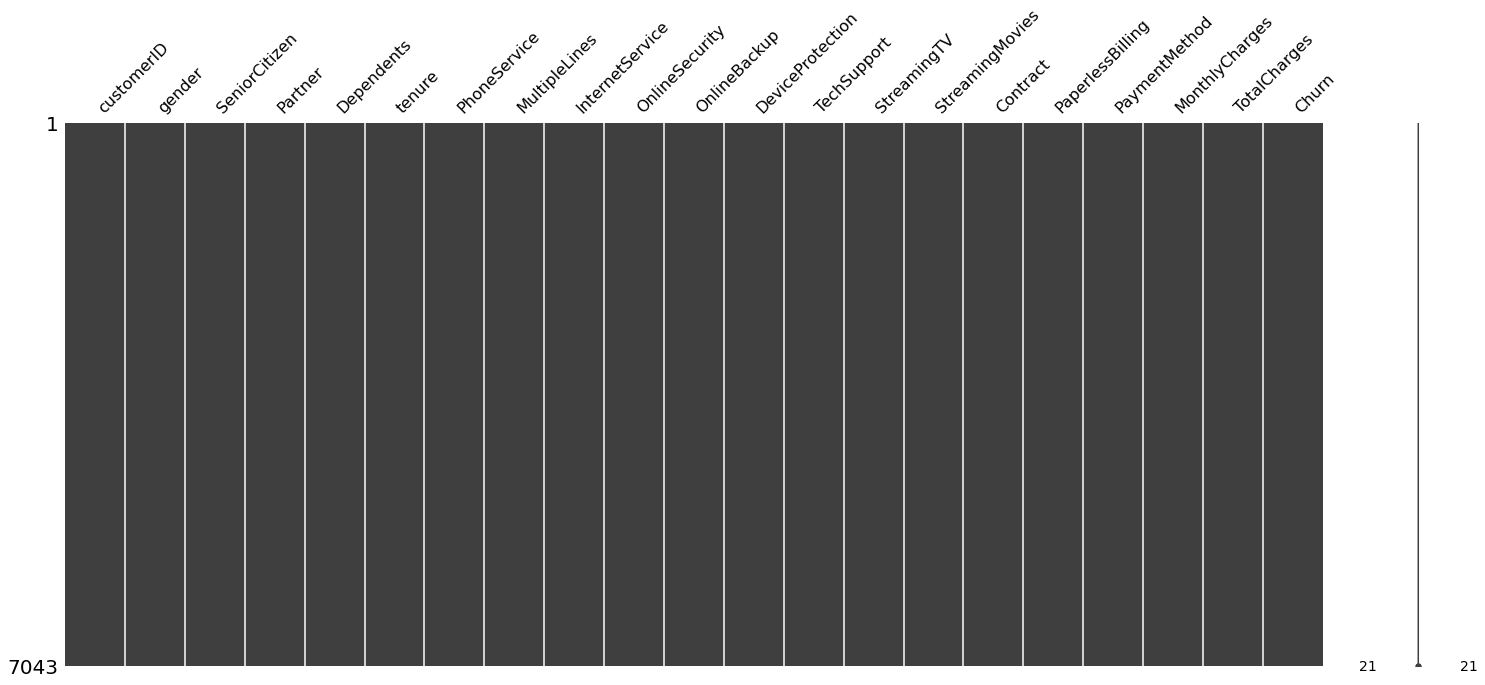

In [6]:
#Visually what the same output would be
msno.matrix(df)

Flat line on the right and no lines within columns indicate completely populated columns.

In [7]:
#How many total churned?
df['Churn'].value_counts(normalize=True)

No     0.73463
Yes    0.26537
Name: Churn, dtype: float64

# Data Processing

Given that customerID is essentially in index since it would not help give any insights into churn, we can drop it.

In [8]:
df.drop(['customerID'], axis = 1 ,inplace = True)

In [9]:
#Upon running to_numeric, realized that missing data could come in the form of empty strings. Let's take care of that
#Once the string column is converted to numeric, the NaN's are exposed and then counted
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors = 'coerce')
df.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [10]:
df[np.isnan(df['TotalCharges'])]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


Another thing to note about data integrity issue is that when tenure is 0, there are monthly charges.

In [11]:
df[df['tenure'] == 0].MonthlyCharges

488     52.55
753     20.25
936     80.85
1082    25.75
1340    56.05
3331    19.85
3826    25.35
4380    20.00
5218    19.70
6670    73.35
6754    61.90
Name: MonthlyCharges, dtype: float64

This is a small percentage of the whole population. So let's eliminate them from the dataset.

In [12]:
df.drop(df[df['tenure'] == 0].index, inplace=True)
df[df['tenure'] == 0]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


To take care of missing values in TotalCharges, will impute with average of distribution.

In [13]:
df.fillna(df['TotalCharges'].mean())

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


In [14]:
df.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

No more NaN's.

Now let's do a few more changes to the data for it to make more readable given context of problem.

In [15]:
df["SeniorCitizen"]= df["SeniorCitizen"].map({0: "No", 1: "Yes"})
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [16]:
#Numerical columns' quantile distribution
df.describe()

,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441
std,24.545260,30.085974,2266.771362
min,1.000000,18.250000,18.800000
25%,9.000000,35.587500,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.862500,3794.737500
max,72.000000,118.750000,8684.800000


In [17]:
churned = df.loc[df['Churn'] == 'Yes']
not_churned = df.loc[df['Churn'] == 'No']
churned

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,Female,No,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,Yes
8,Female,No,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
13,Male,No,No,No,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7021,Male,No,No,No,12,Yes,No,DSL,No,No,No,Yes,Yes,No,One year,Yes,Electronic check,59.80,727.80,Yes
7026,Female,No,No,No,9,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),44.20,403.35,Yes
7032,Male,Yes,No,No,1,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,75.75,75.75,Yes
7034,Female,No,No,No,67,Yes,Yes,Fiber optic,Yes,Yes,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),102.95,6886.25,Yes


In [18]:
#Of Churned, what's the total charges distribution?
churned["TotalCharges"] = pd.to_numeric(churned["TotalCharges"])
churned["TotalCharges"].describe()

count    1869.000000
mean     1531.796094
std      1890.822994
min        18.850000
25%       134.500000
50%       703.550000
75%      2331.300000
max      8684.800000
Name: TotalCharges, dtype: float64

In [19]:
#Of non-Churned, what's the total charges distribution?
not_churned["TotalCharges"] = pd.to_numeric(not_churned["TotalCharges"], errors ='coerce')
not_churned["TotalCharges"].describe()

count    5163.000000
mean     2555.344141
std      2329.456984
min        18.800000
25%       577.825000
50%      1683.600000
75%      4264.125000
max      8672.450000
Name: TotalCharges, dtype: float64

Even though non-churned customers had higher total charges at each quantile, non-churned also were greater portion of population. So their distribution would be more variable.

We can use correlation matrix to see if there are variables that are in line with the target variable - churn. We'll take a look at this later on in our analysis.


# Visualizations

In [20]:
g_labels = ['Male', 'Female']
c_labels = ['No', 'Yes']
# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=g_labels, values=df['gender'].value_counts(), name="Gender"),
              1, 1)
fig.add_trace(go.Pie(labels=c_labels, values=df['Churn'].value_counts(), name="Churn"),
              1, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name", textfont_size=16)

fig.update_layout(
    title_text="Gender and Churn Distributions",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Gender', x=0.16, y=0.5, font_size=20, showarrow=False),
                 dict(text='Churn', x=0.84, y=0.5, font_size=20, showarrow=False)])
fig.show()

This matches what we saw before for percentage breakdown for churn, which is a huge percentage. It would be nice to see from those who churned, what is the breakdown. So let's take a look at that.

In [21]:
df["Churn"][df["Churn"]=="Yes"].groupby(by=df['gender']).count()

gender
Female    939
Male      930
Name: Churn, dtype: int64

Pretty even gender distribution for those who churned.

In [22]:
df["Churn"][df["Churn"]=="No"].groupby(by=df['gender']).count()

gender
Female    2544
Male      2619
Name: Churn, dtype: int64

It's a little skewed more towards males for those who did not churn/less males churned.

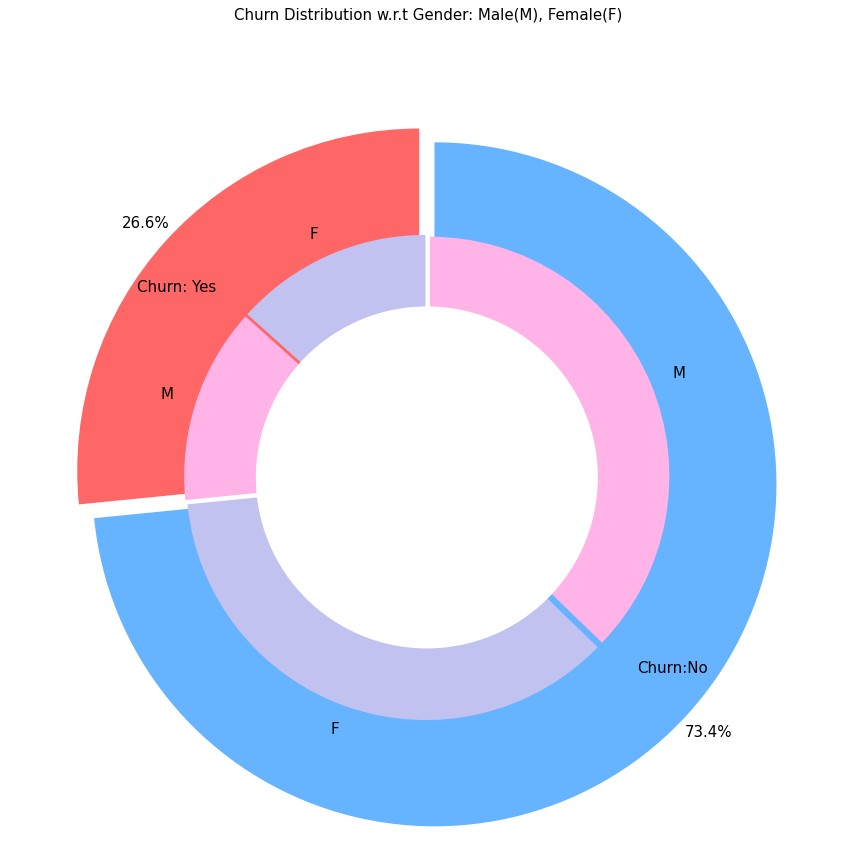

In [23]:
plt.figure(figsize=(12, 12))
labels =["Churn: Yes","Churn:No"]
values = [1869,5163]
labels_gender = ["F","M","F","M"]
sizes_gender = [939,930 , 2544,2619]
colors = ['#ff6666', '#66b3ff']
colors_gender = ['#c2c2f0','#ffb3e6', '#c2c2f0','#ffb3e6']
explode = (0.3,0.3) 
explode_gender = (0.1,0.1,0.1,0.1)
textprops = {"fontsize":15}
#Plot
plt.pie(values, labels=labels,autopct='%1.1f%%',pctdistance=1.08, labeldistance=0.8,colors=colors, startangle=90,frame=True, explode=explode,radius=10, textprops =textprops, counterclock = True, )
plt.pie(sizes_gender,labels=labels_gender,colors=colors_gender,startangle=90, explode=explode_gender,radius=7, textprops =textprops, counterclock = True, )
#Draw circle
centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Churn Distribution w.r.t Gender: Male(M), Female(F)', fontsize=15, y=1.1)

# show plot 
 
plt.axis('equal')
plt.tight_layout()
plt.show()

This is called a starburst visualization which depicts percentage breakdown at each level and from inward to outward you can track a journey, which is not depicted here. In this case, we see churn breakdown and the next level is that within each of churn's breakdown, we see the gender breakdown.


Better investigation is most likely contract/product related to churn.

Let's now take a look at the type of contracts held by those who churned.

In [24]:
fig = px.histogram(df, x="Churn", color="Contract", barmode="group", title="<b>Customer Contract distribution<b>")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

We can see here that the majority of the customer base are month-to-month users followed by longer-term 2-year contracts. When we look more closely at those who churned though, the breakdown is different. The majority are month-to-month and then far behind are oney year and then two year contracts. This makes sense since those that are just trying out and do not see the service as a fit jump ship. 

Those who are month-to-month are not locked in. That is the risk businesses take when they offer this type of commitment to get more users intially signed up. The importance here is to measure LTV - customer Lifetime Value to maintain retention.

If we look into payment method, we can try and see if there is a preferred method of payment between churned and non-churned.  

In [25]:
labels = df['PaymentMethod'].unique()
values = df['PaymentMethod'].value_counts()

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.update_layout(title_text="<b>Payment Method Distribution</b>")
fig.show()

The top two payment methods are common checking and credit card. Suprisingly mailed check still has a strong preference.

Let's see what the breakdown would be between churned and non-churned.

In [26]:
fig = px.histogram(df, x="Churn", color="PaymentMethod", title="<b>Customer Payment Method distribution wrt Churn</b>")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

Electronic payment from checking accounts were the most popular payment method amongst those who churned. This seems to be more a function of the digital age versus main product issue that would result in churn.

Let's look at some other attributes of the customers' service to see if there are any patterns between churn and non-churn.

In [27]:
# Internet Service
fig = px.histogram(df, x="Churn", color="InternetService", title="<b>Internet Service Type distribution wrt Churn</b>")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

Interesting, even though majority of subscribers choose DSL when divided between non-churn and churn, the majority of churners use Fiber. This is something to keep in mind when making conclusions on churners and recommending possible investigation into Fiber product quality.

In [28]:
#Quickly seeing if there is a difference between gender when it came to churn vs non-churn Internet Service Type.
df[df["gender"]=="Male"][["InternetService", "Churn"]].value_counts()

InternetService  Churn
DSL              No       992
Fiber optic      No       910
No               No       717
Fiber optic      Yes      633
DSL              Yes      240
No               Yes       57
dtype: int64

In [29]:
df[df["gender"]=="Female"][["InternetService", "Churn"]].value_counts()

InternetService  Churn
DSL              No       965
Fiber optic      No       889
No               No       690
Fiber optic      Yes      664
DSL              Yes      219
No               Yes       56
dtype: int64

Gender does not play a difference when it came to Internet Service breakdown between those who churned and did not churn.

In [30]:
color_map = {"Yes": "#FF97FF", "No": "#AB63FA"}
fig = px.histogram(df, x="Churn", color="Dependents", barmode="group", title="<b>Dependents Distribution wrt Churn<b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

This just says that majority of customer base does not share its service with dependents.

In [31]:
color_map = {"Yes": '#FFA15A', "No": '#00CC96'}
fig = px.histogram(df, x="Churn", color="tenure", barmode="group", title="<b>Tenure Distribution wrt Churn</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

Tenure is the number of months the customer has stayed with the company. For those who did not churn, the most populous longest tenure is 72 months or 6 years. For those who churned, the most popular tenure is 1 month since contracts have minimum stay of 1 month.

In [32]:
color_map = {"Yes": '#FFA15A', "No": '#00CC96'}
fig = px.histogram(df, x="Churn", color="Partner", barmode="group", title="<b>Partners Distribution wrt Churn</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

Those who churned mostly had no partner, which is different than those who did not churn. There seems to be no correlation here.  Let's take a look at Senior Citizen.

In [33]:
color_map = {"Yes": '#00CC96', "No": '#B6E880'}
fig = px.histogram(df, x="Churn", color="SeniorCitizen", title="<b>Senior Citizen Distribution wrt Churn</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

Most customers are not senior citizens and there is no difference in distribution between those who churn and those who do not churn.

In [34]:
color_map = {"Yes": "#FF97FF", "No": "#AB63FA"}
fig = px.histogram(df, x="Churn", color="OnlineSecurity", barmode="group", title="<b>Online Security wrt Churn</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

Between those who churn and not share similarity with order of security or not with no security being the greatest and then yes followed by not having internet service. One thing to note is that those without online security have the biggest proportion within those who churn. This is something to investigate since this could have factored into the quality of service.

In [35]:
color_map = {"Yes": '#FFA15A', "No": '#00CC96'}
fig = px.histogram(df, x="Churn", color="PaperlessBilling",  title="<b>Paperless Billing wrt Churn</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

Most people use paperless billing. The proportion of those who don't is less with those who churn. Sometimes this is just convenient and even more some services, there is some incentive to it.

In [36]:
fig = px.histogram(df, x="Churn", color="TechSupport",barmode="group",  title="<b>Churn distribution w.r.t. TechSupport</b>")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

Most of those who churned do not carry Tech Support. And this is good signal because might be that if they did they would have gotten any possible reason for churn fixed.

In [37]:
color_map = {"Yes": '#EB9D7D', "No": '#5190A2'}
fig = px.histogram(df, x="Churn", color="StreamingTV", title="<b>Streaming TV Distribution wrt Churn</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

Nothing stands out for churn when it comes to having streaming TV or not. Let's see if it is the same case for streaming movies.

In [38]:
color_map = {"Yes": '#A8AFB5', "No": '#8AAB93'}
fig = px.histogram(df, x="Churn", color="StreamingMovies", title="<b>Streaming Movies Distribution wrt Churn</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

No difference between those who churned and did not churn when it came to streaming movies distribution.

In [39]:
color_map = {"Yes": '#00CC96', "No": '#B6E880'}
fig = px.histogram(df, x="Churn", color="PhoneService", title="<b>Phone Service Distribution wrt Churn</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

Most people carried phone service regardless of churnning or not.

In [40]:
df.MultipleLines.value_counts()

No                  3385
Yes                 2967
No phone service     680
Name: MultipleLines, dtype: int64

In [41]:
color_map = {"Yes": '#760000', "No": '#50596C'}
fig = px.histogram(df, x="Churn", color="MultipleLines", title="<b>Multiple Lines Distribution wrt Churn</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

No that big of a difference when it came to of those with multiple lines who had it and who did not.

In [42]:
color_map = {"Yes": '#E399AD', "No": '#BAB988'}
fig = px.histogram(df, x="Churn", color="OnlineBackup", title="<b>Online Backup Distribution wrt Churn</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

Most who churned did not have online backup.

In [43]:
color_map = {"Yes": '#C9CADE', "No": '#5190A2'}
fig = px.histogram(df, x="Churn", color="DeviceProtection", title="<b>Device Protection Distribution wrt Churn</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

Most of those who churned had no device protection. Most likely because they were not going to be long-term.

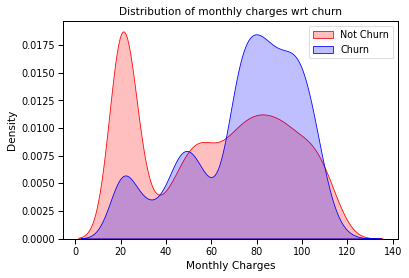

In [44]:
sns.set_context("paper",font_scale=1.1)
ax = sns.kdeplot(df.MonthlyCharges[(df["Churn"] == 'No') ],
                color="Red", shade = True);
ax = sns.kdeplot(df.MonthlyCharges[(df["Churn"] == 'Yes') ],
                ax =ax, color="Blue", shade= True);
ax.legend(["Not Churn","Churn"],loc='upper right');
ax.set_ylabel('Density');
ax.set_xlabel('Monthly Charges');
ax.set_title('Distribution of monthly charges wrt churn');

Now monthly charges is an even better signal for churn because most of the time people cut the chord due to price.

From the above graph, looks like those who are less likely to churn when prices are low and more likely to churn when prices are high. This is common sense. 

What is an important take away is at what price is there price neutrality- where churn and non-churn overlap the most. And the sweet spot looks like around \\$50 which is the usual price people are expected to pay for this product.

# Data Processing for Model Training

Split data into test and training sets.

In [45]:
#reminder
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   object 
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   object 
 6   MultipleLines     7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  Contract          7032 non-null   object 
 15  PaperlessBilling  7032 non-null   object 
 16  PaymentMethod     7032 non-null   object 


In [47]:
def object_to_int(dataframe_series):
    if dataframe_series.dtype=='object':
        dataframe_series = LabelEncoder().fit_transform(dataframe_series)
    return dataframe_series

In [48]:
df = df.apply(lambda x: object_to_int(x))
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


Dataframe series/columns that were string are not turned into numeric data types to perform calculations on.

In [49]:
#Now let's take a look at how much correlation there is with the given features to our target variable: churn
plt.figure(figsize=(14,7))
df.corr()['Churn'].sort_values(ascending = False)

Churn               1.000000
MonthlyCharges      0.192858
PaperlessBilling    0.191454
SeniorCitizen       0.150541
PaymentMethod       0.107852
MultipleLines       0.038043
PhoneService        0.011691
gender             -0.008545
StreamingTV        -0.036303
StreamingMovies    -0.038802
InternetService    -0.047097
Partner            -0.149982
Dependents         -0.163128
DeviceProtection   -0.177883
OnlineBackup       -0.195290
TotalCharges       -0.199484
TechSupport        -0.282232
OnlineSecurity     -0.289050
tenure             -0.354049
Contract           -0.396150
Name: Churn, dtype: float64

<Figure size 1008x504 with 0 Axes>

It makes sense that MonthlyCharges has high correlation with Churn, but it does not make sense that Contract is at the bottom. From the prior visualizations, there seemed to be a high correlation between month-to-month contracts and churn. We can do further analysis to see what other conclusions we can draw from contributions to churn.

In [50]:
X = df.drop(columns = ['Churn'])
y = df['Churn'].values

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 40, stratify=y) 

In [52]:
def distplot(feature, frame, color='r'):
    plt.figure(figsize=(8,3))
    plt.title("Distribution for {}".format(feature))
    ax = sns.distplot(frame[feature], color= color)

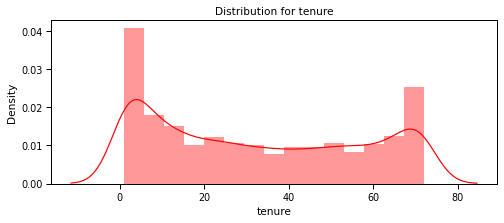

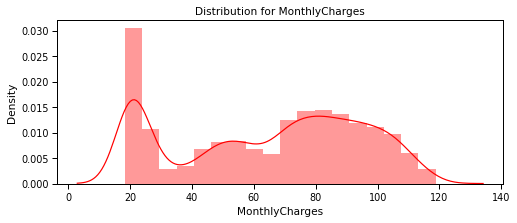

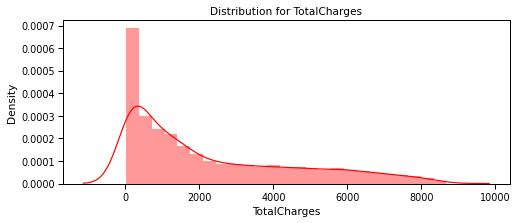

In [53]:
num_cols = ["tenure", 'MonthlyCharges', 'TotalCharges']
for feat in num_cols: distplot(feat, df)

These features have different value ranges. Standard scalar is needed to scale them to same ranges.

## Standardizing numeric attributes.

In [54]:
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

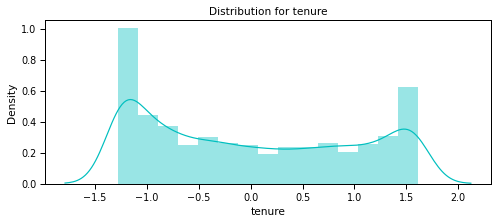

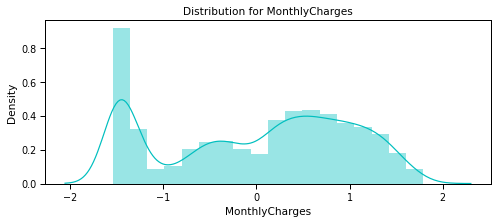

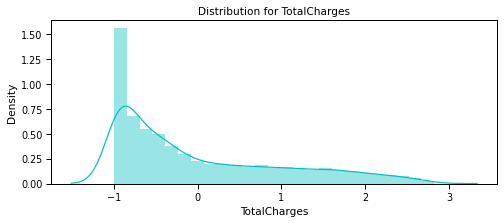

In [55]:
df_std = pd.DataFrame(StandardScaler().fit_transform(df[num_cols].astype('float64')),
                       columns=num_cols)
for feat in numerical_cols: distplot(feat, df_std, color='c')

Need to apply appropriate transformations to non-numerical data for machine learning model to be built properly.

In [56]:
cat_cols_ohe =['PaymentMethod', 'Contract', 'InternetService'] # those that need one-hot encoding (one-hot is best to use when number of values under cat are small)
cat_cols_le = list(set(X_train.columns)- set(num_cols) - set(cat_cols_ohe)) #those that need label encoding (good for many categories/ranked values)

In [57]:
scaler= StandardScaler()

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Machine Learning Model Predictions and Subsequent Evaluations

## K-Nearest Neighbors

In [58]:
knn_model = KNeighborsClassifier(n_neighbors = 11) 
knn_model.fit(X_train,y_train)
predicted_y = knn_model.predict(X_test)
accuracy_knn = knn_model.score(X_test,y_test)
print("KNN accuracy:",accuracy_knn)

KNN accuracy: 0.7753554502369668


In [59]:
print(classification_report(y_test, predicted_y))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1549
           1       0.59      0.52      0.55       561

    accuracy                           0.78      2110
   macro avg       0.71      0.69      0.70      2110
weighted avg       0.77      0.78      0.77      2110



## Support Vector Classifier

In [60]:
svc_model = SVC(random_state = 1)
svc_model.fit(X_train,y_train)
predict_y = svc_model.predict(X_test)
accuracy_svc = svc_model.score(X_test,y_test)
print("SVM accuracy is :",accuracy_svc)

SVM accuracy is : 0.8075829383886256


In [61]:
print(classification_report(y_test, predict_y))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1549
           1       0.69      0.50      0.58       561

    accuracy                           0.81      2110
   macro avg       0.76      0.71      0.73      2110
weighted avg       0.80      0.81      0.80      2110



## Random Forest

In [62]:
model_rf = RandomForestClassifier(n_estimators=500 , oob_score = True, n_jobs = -1,
                                  random_state =50, max_features = "auto",
                                  max_leaf_nodes = 30)
model_rf.fit(X_train, y_train)

# Make predictions
prediction_test = model_rf.predict(X_test)
print (metrics.accuracy_score(y_test, prediction_test))

0.8137440758293839


In [63]:
print(classification_report(y_test, prediction_test))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1549
           1       0.71      0.51      0.59       561

    accuracy                           0.81      2110
   macro avg       0.77      0.72      0.74      2110
weighted avg       0.80      0.81      0.80      2110



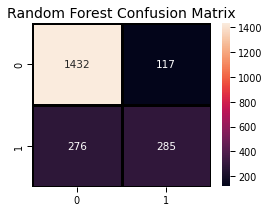

In [64]:
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, prediction_test),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
    
plt.title("Random Forest Confusion Matrix",fontsize=14)
plt.show()

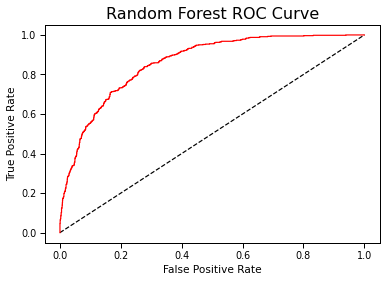

In [65]:
y_rfpred_prob = model_rf.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_rfpred_prob)
plt.plot([0, 1], [0, 1], 'k--' )
plt.plot(fpr_rf, tpr_rf, label='Random Forest',color = "r")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve',fontsize=16)
plt.show();

## Logistic Regression

In [66]:
lr_model = LogisticRegression()
lr_model.fit(X_train,y_train)
accuracy_lr = lr_model.score(X_test,y_test)
print("Logistic Regression accuracy is :",accuracy_lr)

Logistic Regression accuracy is : 0.8090047393364929


In [67]:
lr_pred= lr_model.predict(X_test)
report = classification_report(y_test,lr_pred)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.89      0.87      1549
           1       0.66      0.58      0.62       561

    accuracy                           0.81      2110
   macro avg       0.76      0.74      0.75      2110
weighted avg       0.80      0.81      0.81      2110



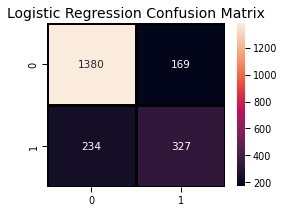

In [68]:
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, lr_pred),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
    
plt.title("Logistic Regression Confusion Matrix",fontsize=14)
plt.show()

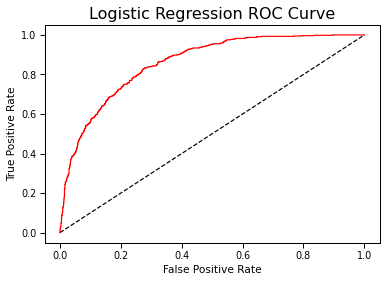

In [69]:
y_pred_prob = lr_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--' )
plt.plot(fpr, tpr, label='Logistic Regression',color = "r")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve',fontsize=16)
plt.show();

## Decision Tree Classifier

In [70]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
predictdt_y = dt_model.predict(X_test)
accuracy_dt = dt_model.score(X_test,y_test)
print("Decision Tree accuracy is :", accuracy_dt)

Decision Tree accuracy is : 0.7303317535545024


In [71]:
print(classification_report(y_test, predictdt_y))

              precision    recall  f1-score   support

           0       0.82      0.81      0.81      1549
           1       0.49      0.51      0.50       561

    accuracy                           0.73      2110
   macro avg       0.66      0.66      0.66      2110
weighted avg       0.73      0.73      0.73      2110



## Adaptive Boosting (AdaBoost)

In [72]:
a_model = AdaBoostClassifier()
a_model.fit(X_train,y_train)
a_preds = a_model.predict(X_test)
print("AdaBoost Classifier accuracy")
metrics.accuracy_score(y_test, a_preds)

AdaBoost Classifier accuracy


0.8075829383886256

In [73]:
print(classification_report(y_test, a_preds))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1549
           1       0.67      0.55      0.60       561

    accuracy                           0.81      2110
   macro avg       0.76      0.72      0.74      2110
weighted avg       0.80      0.81      0.80      2110



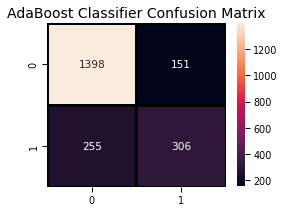

In [74]:
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, a_preds),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
    
plt.title("AdaBoost Classifier Confusion Matrix",fontsize=14)
plt.show()

## Gradient Boosting Classifier

In [75]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)
print("Gradient Boosting Classifier", accuracy_score(y_test, gb_pred))

Gradient Boosting Classifier 0.8080568720379147


In [76]:
print(classification_report(y_test, gb_pred))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1549
           1       0.67      0.55      0.60       561

    accuracy                           0.81      2110
   macro avg       0.76      0.73      0.74      2110
weighted avg       0.80      0.81      0.80      2110



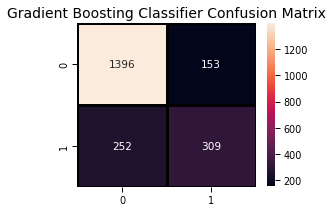

In [77]:
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, gb_pred),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
    
plt.title("Gradient Boosting Classifier Confusion Matrix",fontsize=14)
plt.show()

## Voting Classifier

In [78]:
from sklearn.ensemble import VotingClassifier
clf1 = GradientBoostingClassifier()
clf2 = LogisticRegression()
clf3 = AdaBoostClassifier()
eclf1 = VotingClassifier(estimators=[('gbc', clf1), ('lr', clf2), ('abc', clf3)], voting='soft')
eclf1.fit(X_train, y_train)
predictions = eclf1.predict(X_test)
print("Final Accuracy Score ")
print(accuracy_score(y_test, predictions))

Final Accuracy Score 
0.8170616113744076


In [79]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1549
           1       0.68      0.58      0.63       561

    accuracy                           0.82      2110
   macro avg       0.77      0.74      0.75      2110
weighted avg       0.81      0.82      0.81      2110



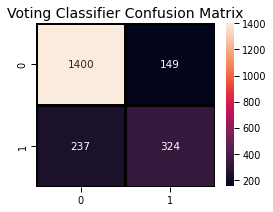

In [80]:
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, predictions),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
    
plt.title("Voting Classifier Confusion Matrix",fontsize=14)
plt.show()

# Conclusion

By looking at f1-scores alone Voting Classifier had the highest scores (least false positives/negatives).

When looking at all the non-churned predicted values (1400 + 149), 1400 were accurate (90%). And of all the churned predicted values (237 + 324), 324 were right (58%). Thus the model had better ability to predict those who did not churn versus those who churned most likely because there were more examples of those who did not churn.

Improvements to model prediction accuracy can be made with better data modeling, model feature development, classification model application.

From an overall business standpoint, we noticed that monthly charge had a high correlation with churn. This makes sense since customers usually want to get what they paid for or more bang for thier buck by getting a great product at a price they are willing to pay for it.

When trying to implement remedies to close-to-churning customers, best to use other investigative measures such as customer support/surveys. This helps get at the root of waning interest or complaints to quickly remedy dissatisfied customers. Once this is resolved then churn is less likely. And when this happens, the business does not have to spend relatively more to acquire new customers.